# Panoptic segmentation using DETR

In this notebook we demonstrate how to explore the panoptic segmentation capabilities of DETR. The prediction occurs in several steps: 

1.   The model predicts a box and a binary mask for each object queries
2.   We filter the predictions for which the confidence is < 85%
3.   Finally, the remaining masks are merged together using a pixel-wise argmax

For simplicity, we rely on DETR's postprocessor to execute 2 and 3. We encourage to take a look at the corresponding code to get a better understanding of the process.

Finally, we visualize the final prediction using Detectron2.

## Preliminaries

This section contains the necessary boiler-plate. Run it first.

In [1]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

The panoptic API is required for panoptic inference

In [2]:
! pip install git+https://github.com/cocodataset/panopticapi.git


^C


In [16]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [17]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [2]:
# These are the COCO classes
CLASSES = [
    'N/A','PL', 'TT', '2', '3'
]


# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Using a model from hub

We load a pre-trained model directly from torch hub. Note that we also request the post-processor

In [3]:
import random
import warnings
warnings.filterwarnings('ignore')

import requests
import torch
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn.functional import linear
from torch.nn.functional import softmax,relu

from models.backbone import Backbone, Joiner
from models.detr import DETR, DETRsegm, PostProcess
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.segmentation import PostProcessSegm,PostProcessPanoptic
from util.misc import (NestedTensor, nested_tensor_from_tensor_list)

torch.set_grad_enabled(False)
%matplotlib inline

In [10]:
hidden_dim = 256
dropout = 0.1
nheads = 8
dim_feedforward = 2048
enc_layers = 6
dec_layers = 6
pre_norm = False
num_classes = 4+1
num_queries = 20
aux_loss = True

In [11]:
backbone = Backbone('resnet50', True, True, False)

In [12]:
N_steps = hidden_dim // 2
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
model = Joiner(backbone, position_embedding)
model.num_channels = backbone.num_channels
backbone = model

In [13]:
transformer = Transformer(
    d_model=hidden_dim,
    dropout=dropout,
    nhead=nheads,
    dim_feedforward=dim_feedforward,
    num_encoder_layers=enc_layers,
    num_decoder_layers=dec_layers,
    normalize_before=pre_norm,
    return_intermediate_dec=True,
)
model = DETR(
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=num_queries,
    aux_loss=aux_loss,
)

In [14]:
model = DETRsegm(model, freeze_detr=False)

In [15]:
model.load_state_dict(torch.load("./output/seg/checkpoint.pth")['model'])
model.eval();

In [26]:
postprocessors = {'bbox': PostProcess()}
postprocessors['segm'] = PostProcessSegm()

In [30]:
postprocessor=postprocessors

Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

In [16]:
im = Image.open("D:/dataset/coco_powerline_1/train/04_585.jpg")

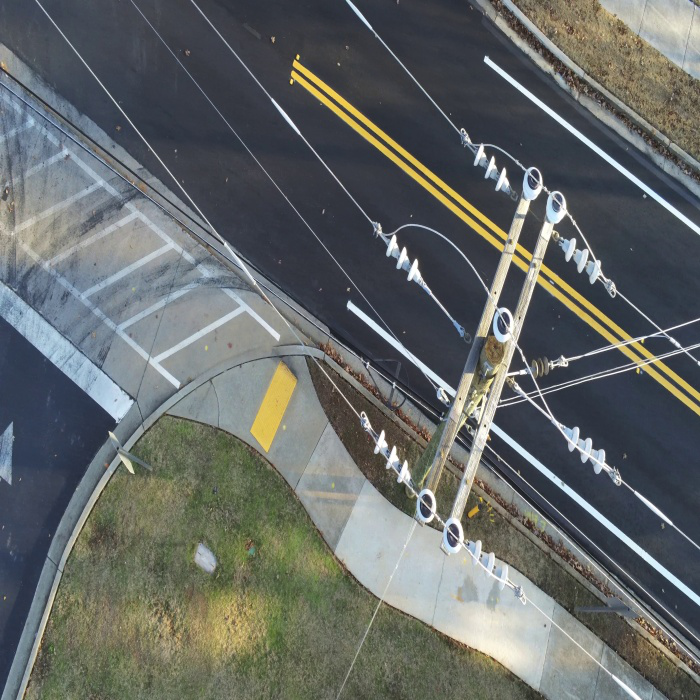

In [17]:
im

Finally, we run the prediction

In [18]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
img.shape


torch.Size([1, 3, 800, 800])

In [19]:
out = model(img)

features: 4


In [22]:
out

{'pred_logits': tensor([[[  2.6086,  -1.2594,  -1.7166,   0.5053,  -7.7437,   1.4295],
          [  2.9382,  -1.4286,  -2.3553,  -0.0754,  -9.1593,   1.7988],
          [  4.5004,  -3.3072,  -4.2943,  -1.8574,  -9.9342,   2.8283],
          [  4.0605,  -2.4739,  -3.9253,  -1.5395, -11.2972,   2.5567],
          [  2.1880,  -1.2517,  -1.8918,   0.5823,  -8.9773,   1.5953],
          [  1.9983,  -0.7195,  -1.7670,   0.7079,  -8.4377,   1.6479],
          [  2.6545,  -0.9563,  -1.9750,   0.0755,  -8.6875,   1.6501],
          [  2.7081,  -0.7550,  -1.9198,   0.2953,  -8.5567,   1.7863],
          [  3.4354,  -2.2634,  -3.8093,  -0.8501, -11.1061,   2.7160],
          [  4.8260,  -3.2794,  -4.4325,  -1.8049, -10.3872,   2.8266],
          [  1.0744,  -0.5527,  -0.8627,   1.5875,  -6.8008,   1.0586],
          [  1.6418,  -0.9064,  -2.1153,   0.5391,  -9.1031,   1.7225],
          [  1.7889,  -0.4947,  -1.6436,   0.5523,  -8.4691,   1.4103],
          [  2.2050,  -0.7351,  -1.6328,   0.4986

This returns a mask for each query, let us visualize the high confidence ones

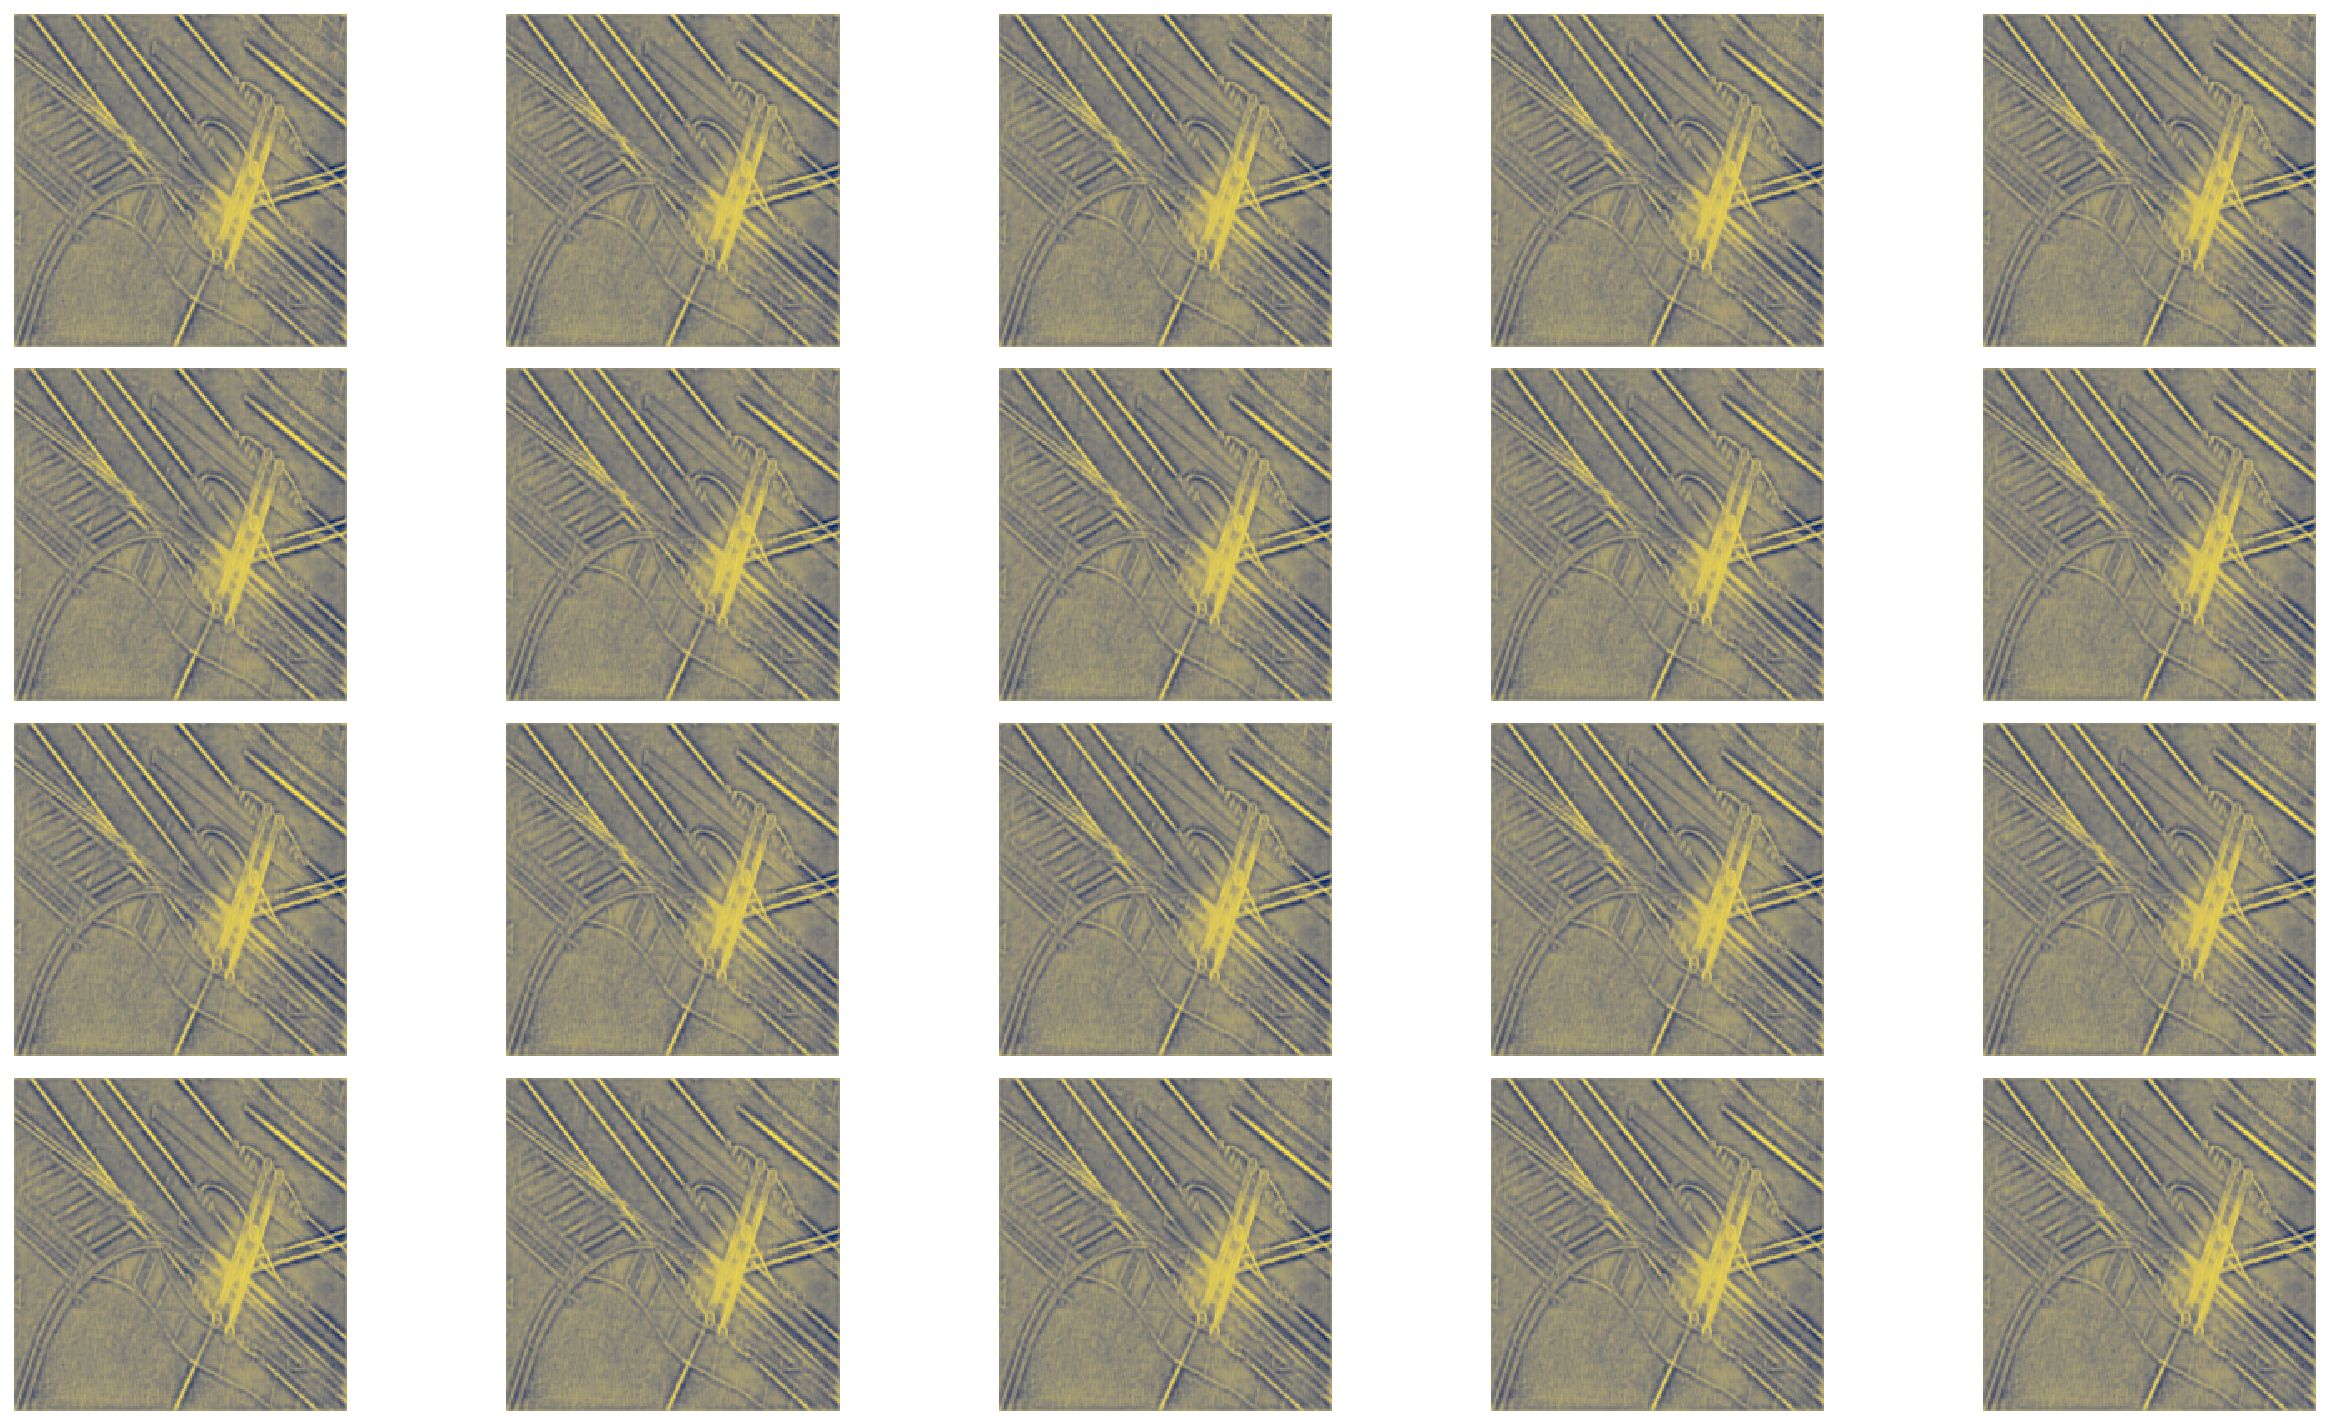

In [21]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Now that we have the individual masks, we can merge the predictions into a unified panoptic segmentation. We use DETR's postprocessor for that.



In [ ]:
for samples, targets in metric_logger.log_every(data_loader, 10, header):
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
target_sizes = torch.stack([t["size"] for t in targets], dim=0)
results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)

In [48]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = PostProcessPanoptic.forward(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))
result=result[0]

TypeError: forward() missing 1 required positional argument: 'processed_sizes'

We can now do a simple visualization of the result

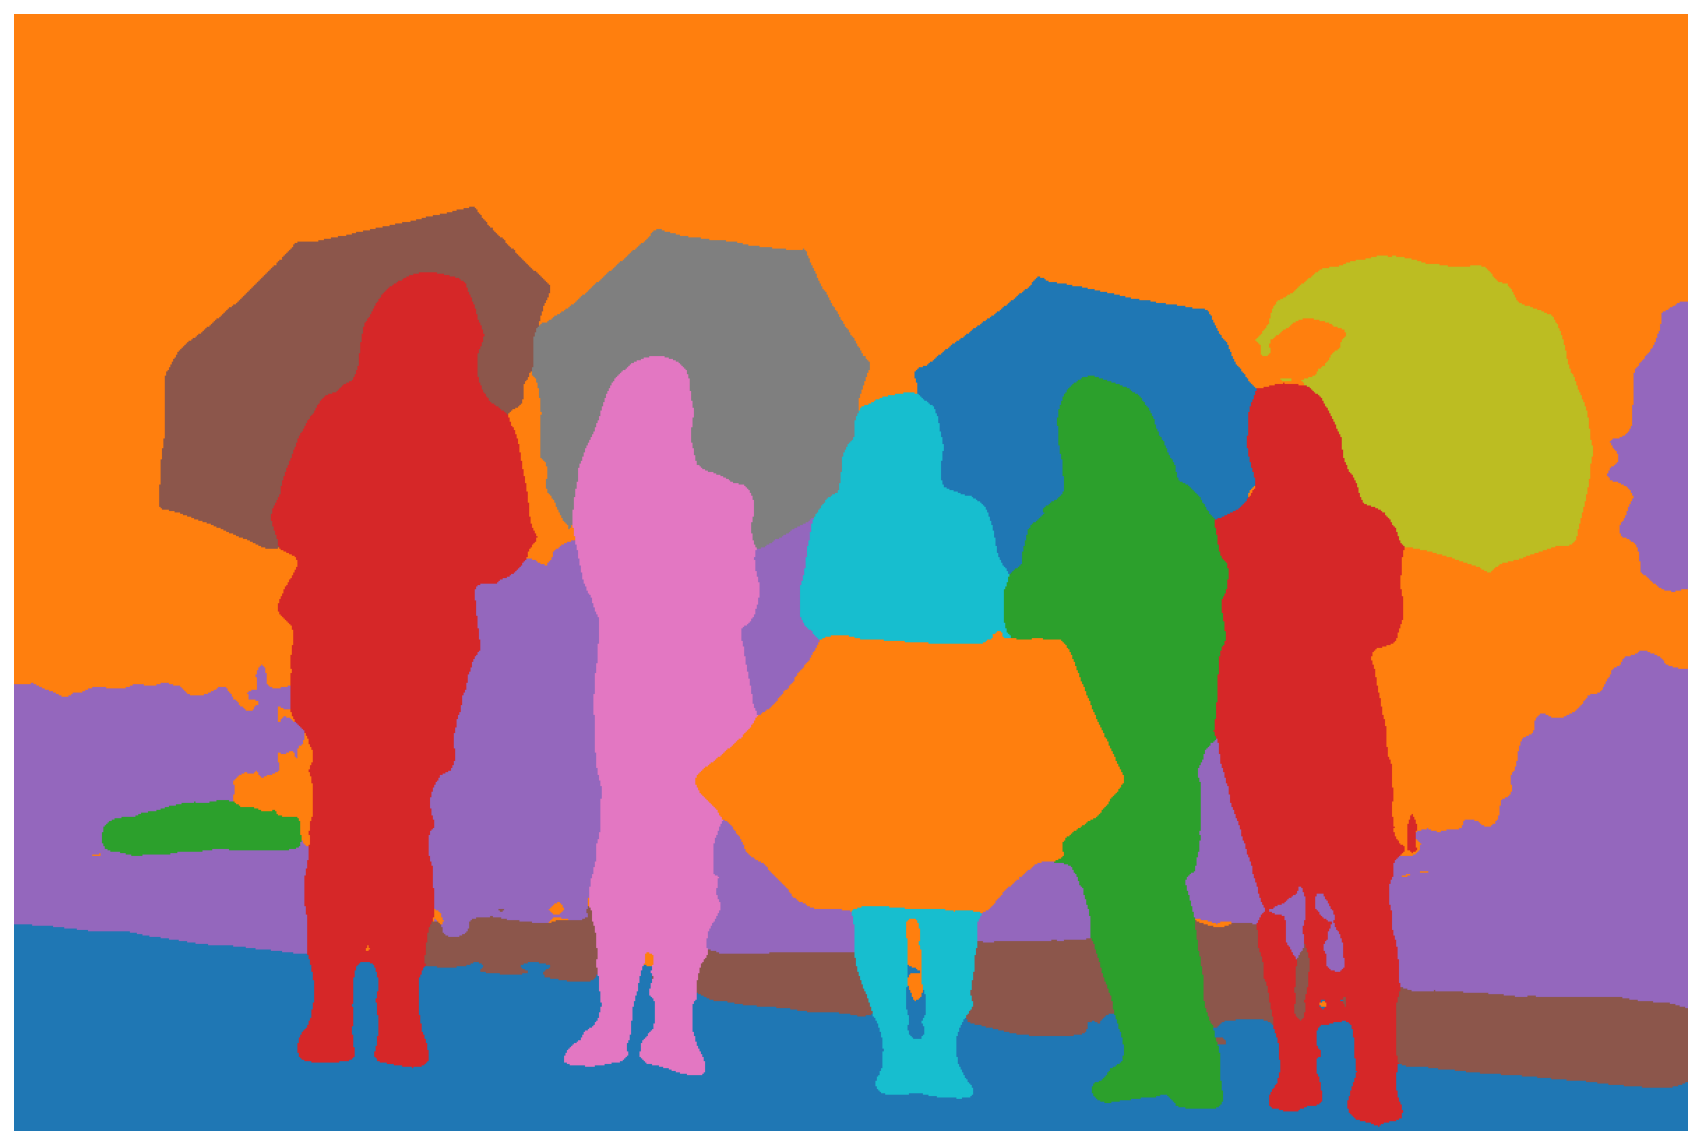

In [ ]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

## Panoptic visualization using Detectron2

In this section we demonstrate how to obtain a better looking visualization by leveraging Detectron2's plotting utilities.

In [4]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Cloning https://github.com/cocodataset/panopticapi.git to d:\temp\pip-req-build-n3wnixxl
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git 'D:\Temp\pip-req-build-n3wnixxl'
ERROR: Could not find a version that satisfies the requirement detectron2==0.1.3 (from versions: none)
ERROR: No matching distribution found for detectron2==0.1.3


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
Could not fetch URL https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='dl.fbaipublicfiles.com', port=443): Max retries exceeded with url: /detectron2/wheels/cu101/torch1.5/index.html (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping
Could not fetch URL https://pypi.tuna.tsinghua.edu.cn/simple/detectron2/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.tuna.tsinghua.edu.cn', port=443): Max retries exceeded with url: /simple/detectron2/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)'))) - skipping


ModuleNotFoundError: No module named 'detectron2'

Finally, we visualize it

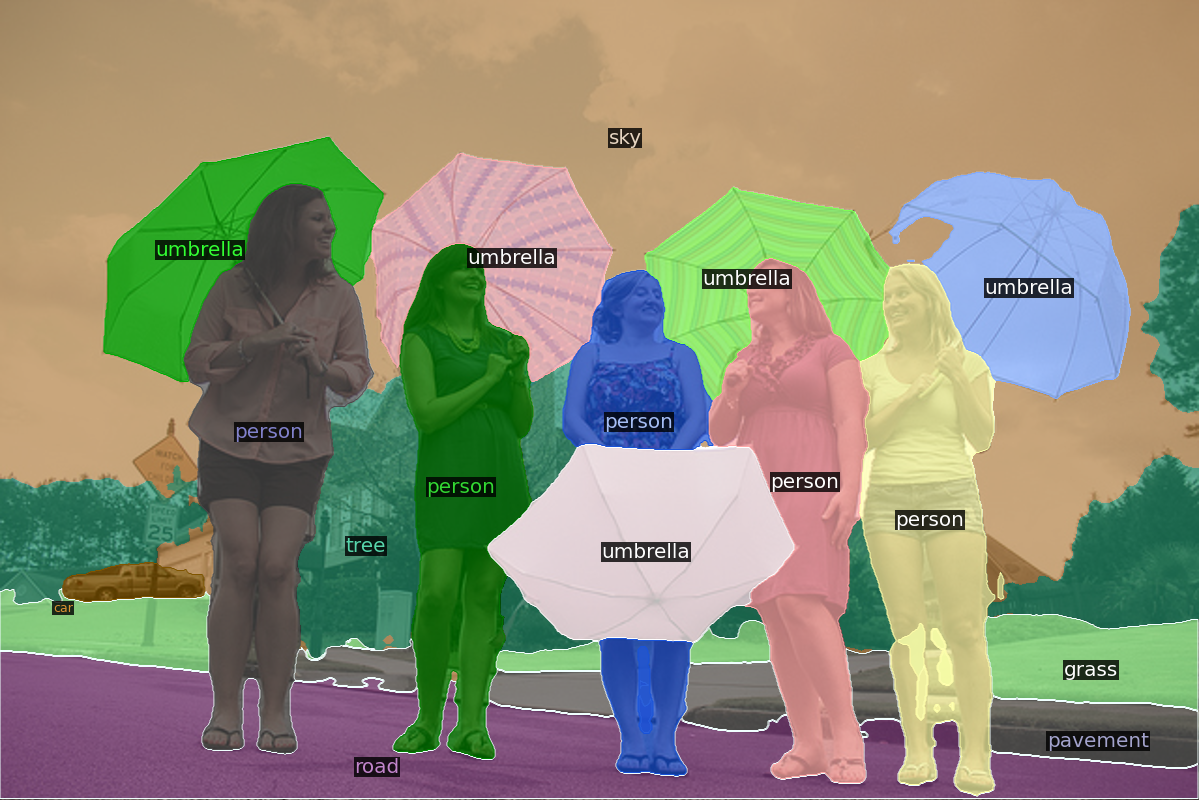

In [ ]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())